# Regresor

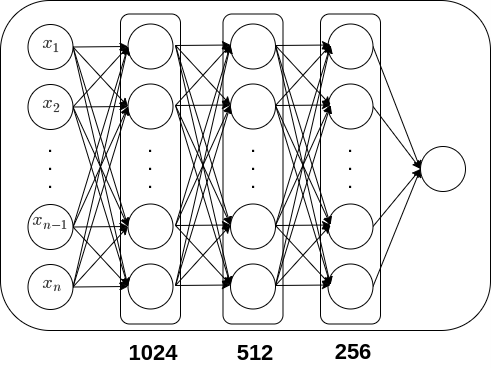

## Validación cruzada con los datos de Natalia
- [x] Agregar la métrica de RMSE.
- [x] Cambiar las gráficas para que se distingan por marcadores y solo con los puntos discretos.
- [x] Probar con los datos GKM.
- [x] Cambiar ReLu por Swish.
- [ ] Variar el número de capas ocultas (1 a 4 capas (hard_sigmoid al inicio), (a menor número de capas se quitan las primeras funciones)).

In [59]:
#Librerías
import sofa
import polars as pl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow.keras as ker

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import models, regularizers, Sequential, utils
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from time import time

%store -r

In [2]:
def estimation_model(input_dim, layers_props_lst):
    model = ker.Sequential()
    # Capas ocultas
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(**layer_props, input_dim=input_dim))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Regresor
    model.add(ker.layers.Dense(units=1, activation="linear"))

    # Compilar modelo
    model.compile(loss="mean_absolute_error", optimizer="adam")

    return model


def crossvalidation(X, y, n_splits, layer_props, callbacks):
    # Para calcular el tiempo que tarda
    t0 = time()

    # Diccionario donde se almacenarán los puntajes
    scores = {}
    scores["mae"] = {"train": [], "test": []}
    scores["r2"] = {"train": [], "test": []}
    scores["rmse"] = {"train": [], "test": []}
    
    # Se hace un K-Fold
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Estandarización de las variables de entrada
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)

        model = estimation_model(X_train.shape[1], layer_props)
        # Guardar la pérdida escalar de prueba (Test scalar loss)
        if callbacks:
            loss = model.fit(
                X_train, y_train, epochs=5000, batch_size=64, verbose=0, callbacks=callbacks
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Needed iterations: {len(loss.history['loss'])}")
        
        # Se predice con los datos de entrenamiento
        predictions_train = model.predict(X_train)
        # Se predice con los datos de prueba
        predictions_test = model.predict(X_test_kf)

        # Se crea un dataframe con los resultados para visualizarlos mejor
        train_data_train = pl.DataFrame(
            {"ICI": [y_train], "Predicted ICI": [predictions_train]}
        )
        train_data_test = pl.DataFrame(
            {"ICI": [y_test], "Predicted ICI": [predictions_test]}
        )

        # Cálculo del MAE
        mae_score_train = mean_absolute_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        mae_score_test = mean_absolute_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # Cálculo de R²
        r2_score_train = r2_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        r2_score_test = r2_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )
         
        # Cálculo de RMSE
        rmse_score_train = mean_squared_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"],
            squared=False
        )
        rmse_score_test = mean_squared_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"],
            squared=False
        )

        # Anexo a las listas
        scores["mae"]["train"].append(mae_score_train)
        scores["mae"]["test"].append(mae_score_test)
        scores["r2"]["train"].append(r2_score_train)
        scores["r2"]["test"].append(r2_score_test)
        scores["rmse"]["train"].append(rmse_score_train)
        scores["rmse"]["test"].append(rmse_score_test)
        
    print(f"Time elapsed: {(time() - t0)/60:.2f} minutes")

    return scores


def test_model(data, n_splits, max_neurons, activations):
    """ Probar un modelo con parámetros establecidos. """
    variables = 17

    # Separando variables
    # Variables
    X = np.array(data[:, 0:variables]).T
    # Etiquetas
    y = np.array(data[:, 19:20]).T
    
    # Propiedades de las capas
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(layer_props)
    callbacks = [
        EarlyStopping(monitor="loss", patience=300, mode="min", restore_best_weights=True)
    ]
    
    return crossvalidation(X, y, n_splits, layer_props, callbacks)


def smooth_line(x, y):
    x_smooth = np.linspace(x[0], x[-1], 1000)
    bspline = sp.interpolate.make_interp_spline(x, y)
    y_smooth = bspline(x_smooth)

    return x_smooth, y_smooth


def plot_neurons_scores(scores, max_neurons, scenario):
    score_names = ["mae", "r2", "rmse"]
    markers = ["*", "x", "^", "+"]
    data_type = ["train", "test"]
    
    plt.figure(figsize=(16, 4*len(scores)))
    
    i = 0
    for sn in score_names:
        for dt in data_type:
            plt.subplot(3, 2, i + 1)
            plt.suptitle(scenario, size="x-large", y=0.92)
            for j, (score, neurons) in enumerate(zip(scores, max_neurons)):
                points = score[sn][dt]

                k = np.arange(len(points), dtype = np.uint8) + 1
                 
                plt.scatter(k, points, marker=markers[j], label=f"n = {neurons}, µ = {np.mean(points):.3f}",
                            s = 100)
                
            plt.title(f"{'Train' if dt == 'train' else 'Test'}")
            plt.xlabel("k-fold")
            plt.xticks(k)
            plt.ylabel("MAE" if sn == "mae" else "R²" if sn == "r2" else "RMSE")
            plt.grid(True)
            plt.legend(loc="upper right")
            i += 1

def plot_activations_scores(scores, scenario):
    score_names = ["mae", "r2", "rmse"]
    markers = ["o", "v", "X", "P"]
    data_type = ["train", "test"]
    
    plt.figure(figsize=(16, 4*len(scores)))
    
    i = 0
    for sn in score_names:
        for dt in data_type:
            plt.subplot(3, 2, i + 1)
            plt.suptitle(scenario, size="x-large", y=0.92)
            for j, score in enumerate(scores):
                points = score[sn][dt]

                k = np.arange(len(points), dtype = np.uint8) + 1
                 
                plt.scatter(k, points, marker=markers[j], 
                            label=f"{'FCM' if j%2 == 0 else 'GKM'} {'ReLu' if j<2 else 'Swish'}, µ = {np.mean(points):.3f}",
                            s = 100)
                
            plt.title(f"{'Train' if dt == 'train' else 'Test'}")
            plt.xlabel("k-fold")
            plt.xticks(k)
            plt.ylabel("MAE" if sn == "mae" else "R²" if sn == "r2" else "RMSE")
            plt.grid(True)
            plt.legend(loc="upper right")
            i += 1
            
def calc_once(varname, fn, args):
    """ Calcular una variable una sola vez. """
    if varname not in globals():
        return fn(**args)
    return eval(varname)

## FCM

In [3]:
# Para leer los datos
data_file_FCM = "../Databases/CaractFCM.csv"
df_FCM = pl.read_csv(data_file_FCM, dtypes=[pl.Float64], has_header=False)

# Separación por escenarios
# Datos sin fibra (B2B)
df_FCM_B2B = df_FCM[0:987, :]
# Datos con fibra óptica a 0dBm
df_FCM_fiber0 = df_FCM[988:1520, :]
# Datos con fibra óptica a 9dBm
df_FCM_fiber9 = df_FCM[1521:, :]

### Crosvalidación para FCM B2B variando el número de neuronas por capa

In [4]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_1024_B2B = calc_once("scores_FCM_1024_B2B", test_model, args)

In [5]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_512_B2B = calc_once("scores_FCM_512_B2B", test_model, args)

In [6]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_256_B2B = calc_once("scores_FCM_256_B2B", test_model, args)

In [7]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_128_B2B = calc_once("scores_FCM_128_B2B", test_model, args)

In [8]:
%store scores_FCM_1024_B2B
%store scores_FCM_512_B2B 
%store scores_FCM_256_B2B
%store scores_FCM_128_B2B

Stored 'scores_FCM_1024_B2B' (dict)
Stored 'scores_FCM_512_B2B' (dict)
Stored 'scores_FCM_256_B2B' (dict)
Stored 'scores_FCM_128_B2B' (dict)


#### Gráficas de puntajes (FCM B2B)

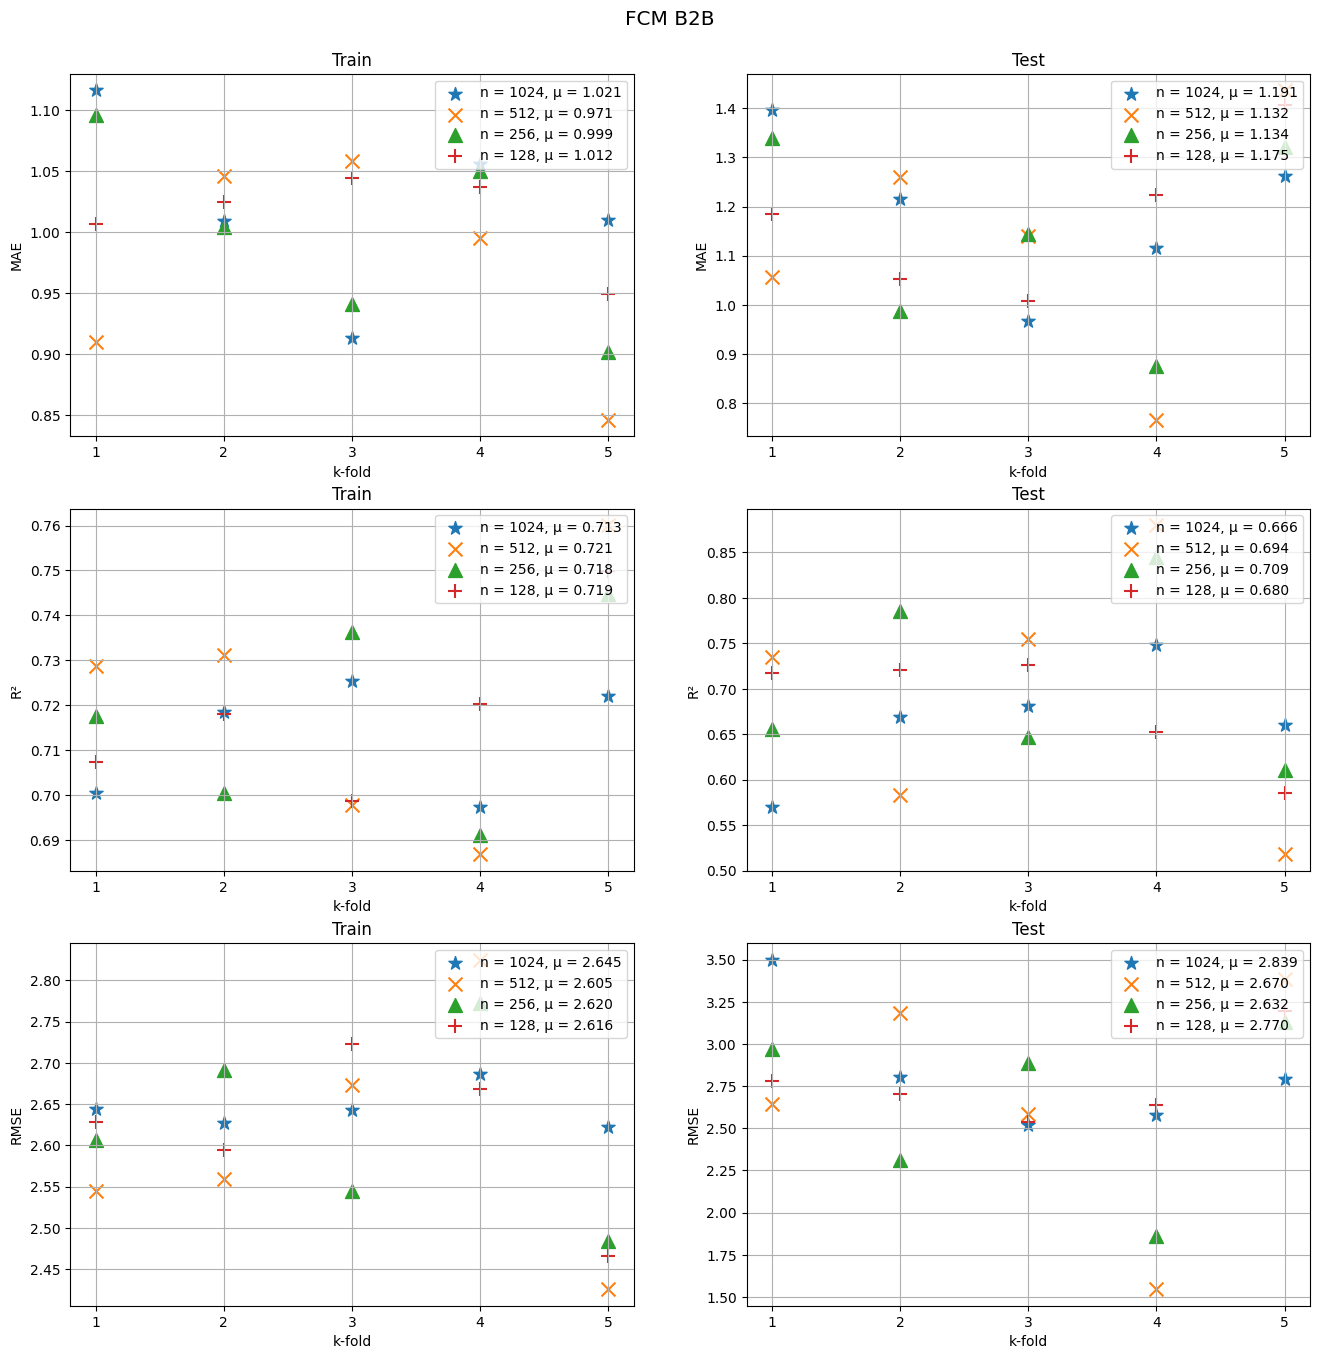

In [9]:
scores = [scores_FCM_1024_B2B, scores_FCM_512_B2B, scores_FCM_256_B2B, scores_FCM_128_B2B]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "FCM B2B")

### Crosvalidación para FCM con fibra óptica a 0dBm variando el número de neuronas por capa

In [10]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_1024_fiber0 = calc_once("scores_FCM_1024_fiber0", test_model, args)

In [11]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_512_fiber0 = calc_once("scores_FCM_512_fiber0", test_model, args)

In [12]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_256_fiber0 = calc_once("scores_FCM_256_fiber0", test_model, args)

In [13]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_128_fiber0 = calc_once("scores_FCM_128_fiber0", test_model, args)

In [14]:
%store scores_FCM_1024_fiber0 
%store scores_FCM_512_fiber0 
%store scores_FCM_256_fiber0 
%store scores_FCM_128_fiber0

Stored 'scores_FCM_1024_fiber0' (dict)
Stored 'scores_FCM_512_fiber0' (dict)
Stored 'scores_FCM_256_fiber0' (dict)
Stored 'scores_FCM_128_fiber0' (dict)


#### Gráficas de puntajes (FCM con fibra óptica a 0dBm)

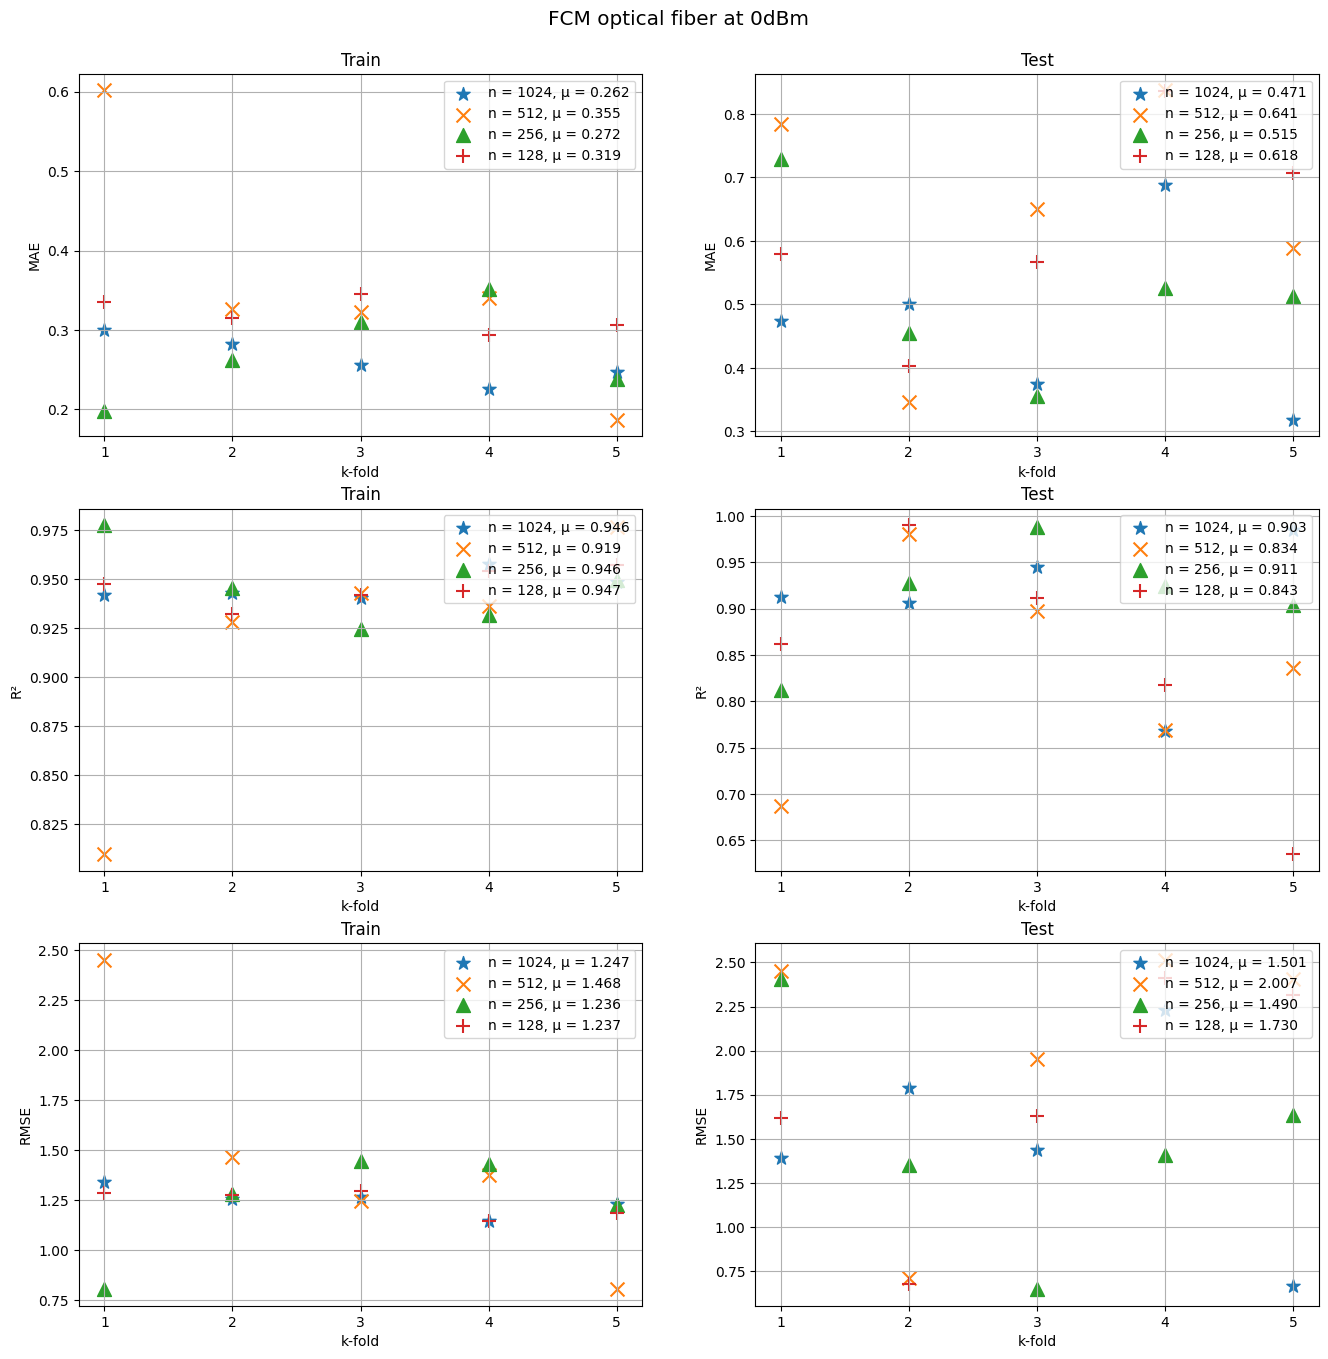

In [15]:
scores = [scores_FCM_1024_fiber0, scores_FCM_512_fiber0, scores_FCM_256_fiber0, scores_FCM_128_fiber0]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "FCM optical fiber at 0dBm")

### Crosvalidación para FCM con fibra óptica a 9dBm variando el número de neuronas por capa

In [16]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_1024_fiber9 = calc_once("scores_FCM_1024_fiber9", test_model, args)

In [17]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_512_fiber9 = calc_once("scores_FCM_512_fiber9", test_model, args)

In [18]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_256_fiber9 = calc_once("scores_FCM_256_fiber9", test_model, args)

In [19]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_128_fiber9 = calc_once("scores_FCM_128_fiber9", test_model, args)

In [20]:
%store scores_FCM_1024_fiber9
%store scores_FCM_512_fiber9 
%store scores_FCM_256_fiber9 
%store scores_FCM_128_fiber9

Stored 'scores_FCM_1024_fiber9' (dict)
Stored 'scores_FCM_512_fiber9' (dict)
Stored 'scores_FCM_256_fiber9' (dict)
Stored 'scores_FCM_128_fiber9' (dict)


#### Gráficas de puntajes (FCM con fibra óptica a 9dBm)

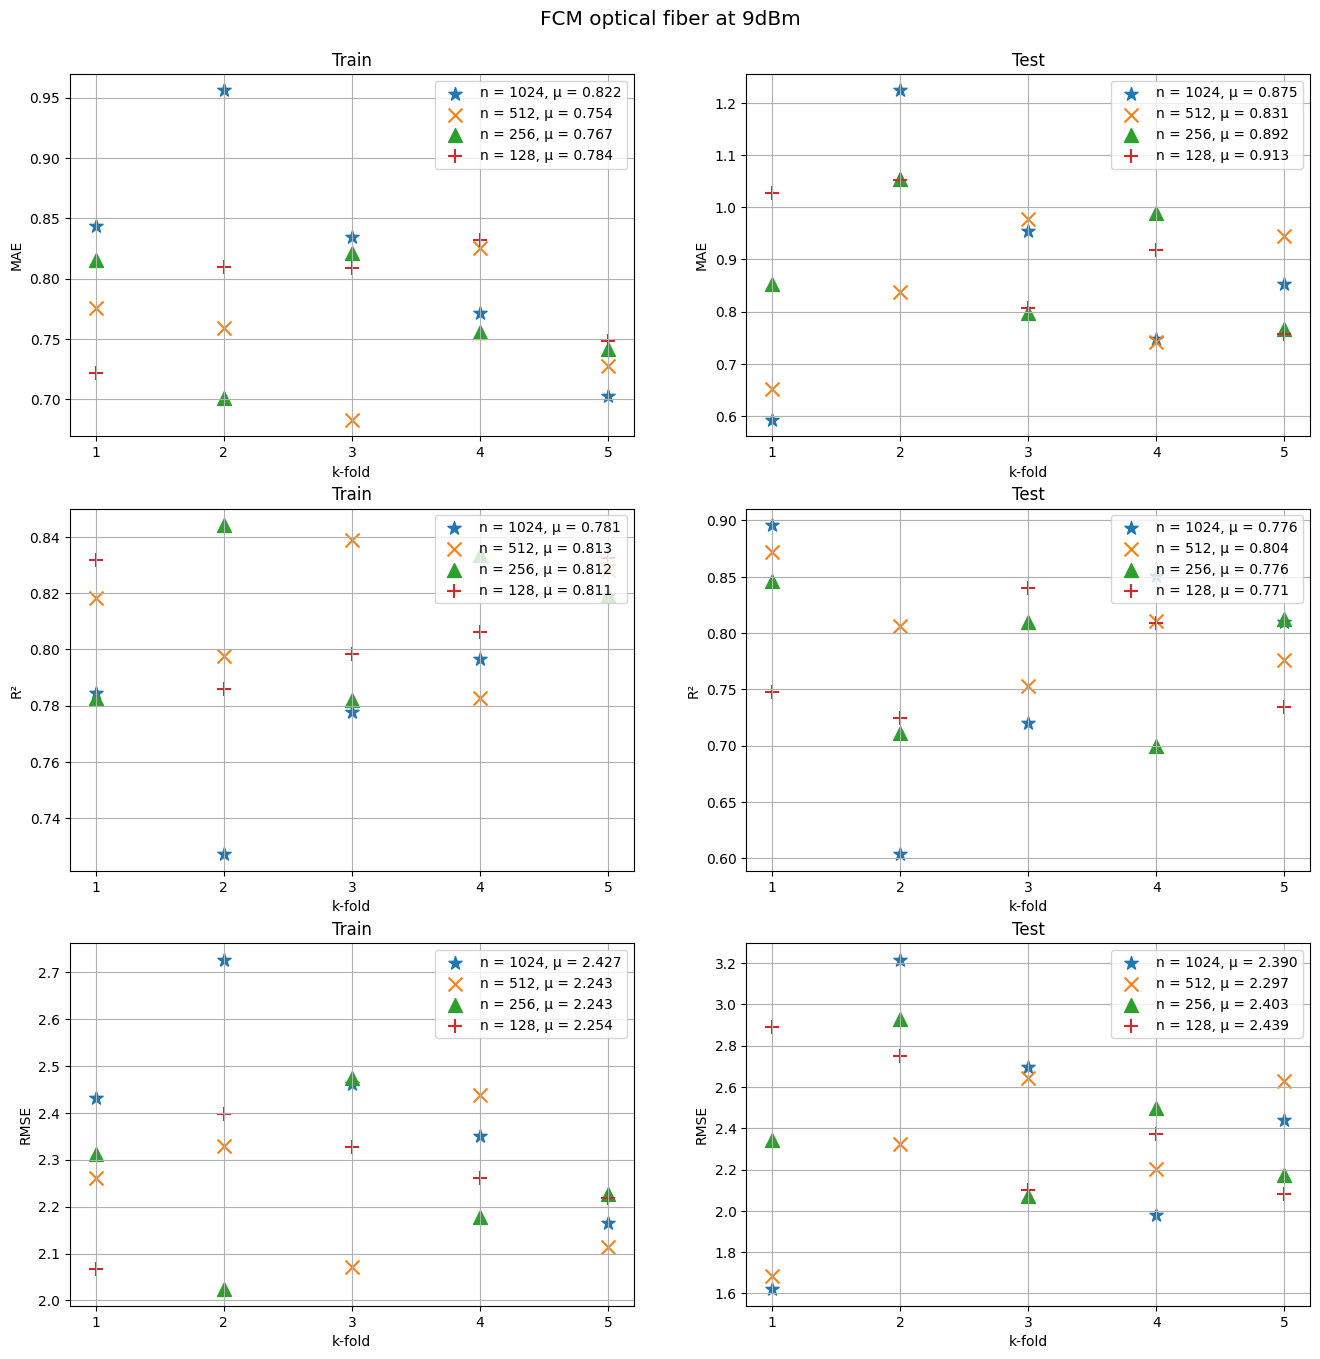

In [21]:
scores = [scores_FCM_1024_fiber9, scores_FCM_512_fiber9, scores_FCM_256_fiber9, scores_FCM_128_fiber9]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "FCM optical fiber at 9dBm")

## GKM

In [22]:
# Para leer los datos
data_file_GKM = "../BasesDeDatos/CaractGKM.csv"
df_GKM = pl.read_csv(data_file_GKM, dtypes=[pl.Float64], infer_schema_length = 10000, has_header=False)

# Separación por escenarios
# Datos sin fibra (B2B)
df_GKM_B2B = df_GKM[0:987, :]
# Datos con fibra óptica a 0dBm
df_GKM_fiber0 = df_GKM[988:1520, :]
# Datos con fibra óptica a 9dBm
df_GKM_fiber9 = df_GKM[1521:, :]

### Crosvalidación para GKM B2B variando el número de neuronas por capa

In [23]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_B2B = calc_once("scores_GKM_1024_B2B", test_model, args)

In [24]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_B2B = calc_once("scores_GKM_512_B2B", test_model, args)

In [25]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_B2B = calc_once("scores_GKM_256_B2B", test_model, args)

In [26]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_B2B = calc_once("scores_GKM_128_B2B", test_model, args)

In [27]:
%store scores_GKM_1024_B2B
%store scores_GKM_512_B2B
%store scores_GKM_256_B2B
%store scores_GKM_128_B2B

Stored 'scores_GKM_1024_B2B' (dict)
Stored 'scores_GKM_512_B2B' (dict)
Stored 'scores_GKM_256_B2B' (dict)
Stored 'scores_GKM_128_B2B' (dict)


#### Gráficas de puntajes (GKM B2B)

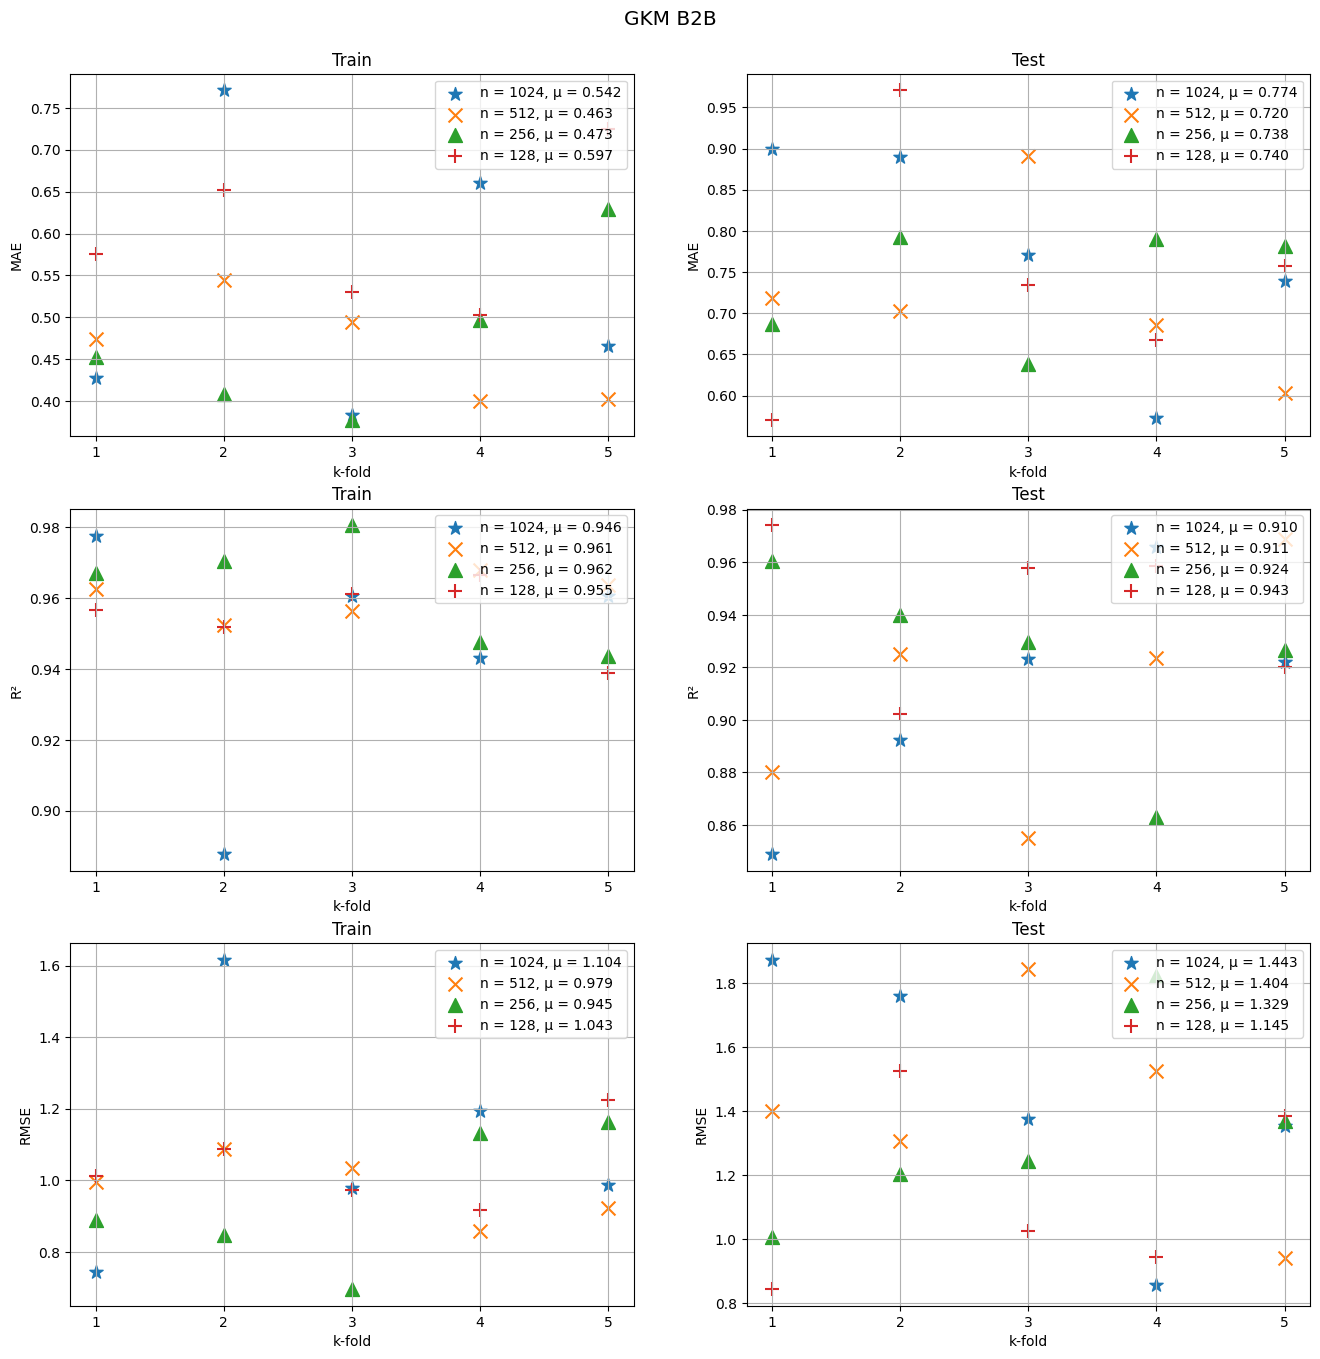

In [28]:
scores = [scores_GKM_1024_B2B, scores_GKM_512_B2B, scores_GKM_256_B2B, scores_GKM_128_B2B]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "GKM B2B")

### Crosvalidación para GKM con fibra óptica a 0dBm variando el número de neuronas por capa

In [29]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_fiber0 = calc_once("scores_GKM_1024_fiber0", test_model, args)

In [30]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_fiber0 = calc_once("scores_GKM_512_fiber0", test_model, args)

In [31]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_fiber0 = calc_once("scores_GKM_256_fiber0", test_model, args)

In [32]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_fiber0 = calc_once("scores_GKM_128_fiber0", test_model, args)

In [33]:
%store scores_GKM_1024_fiber0
%store scores_GKM_512_fiber0
%store scores_GKM_256_fiber0
%store scores_GKM_128_fiber0

Stored 'scores_GKM_1024_fiber0' (dict)
Stored 'scores_GKM_512_fiber0' (dict)
Stored 'scores_GKM_256_fiber0' (dict)
Stored 'scores_GKM_128_fiber0' (dict)


#### Gráficas de puntajes (GKM con fibra óptica a 0dBm)

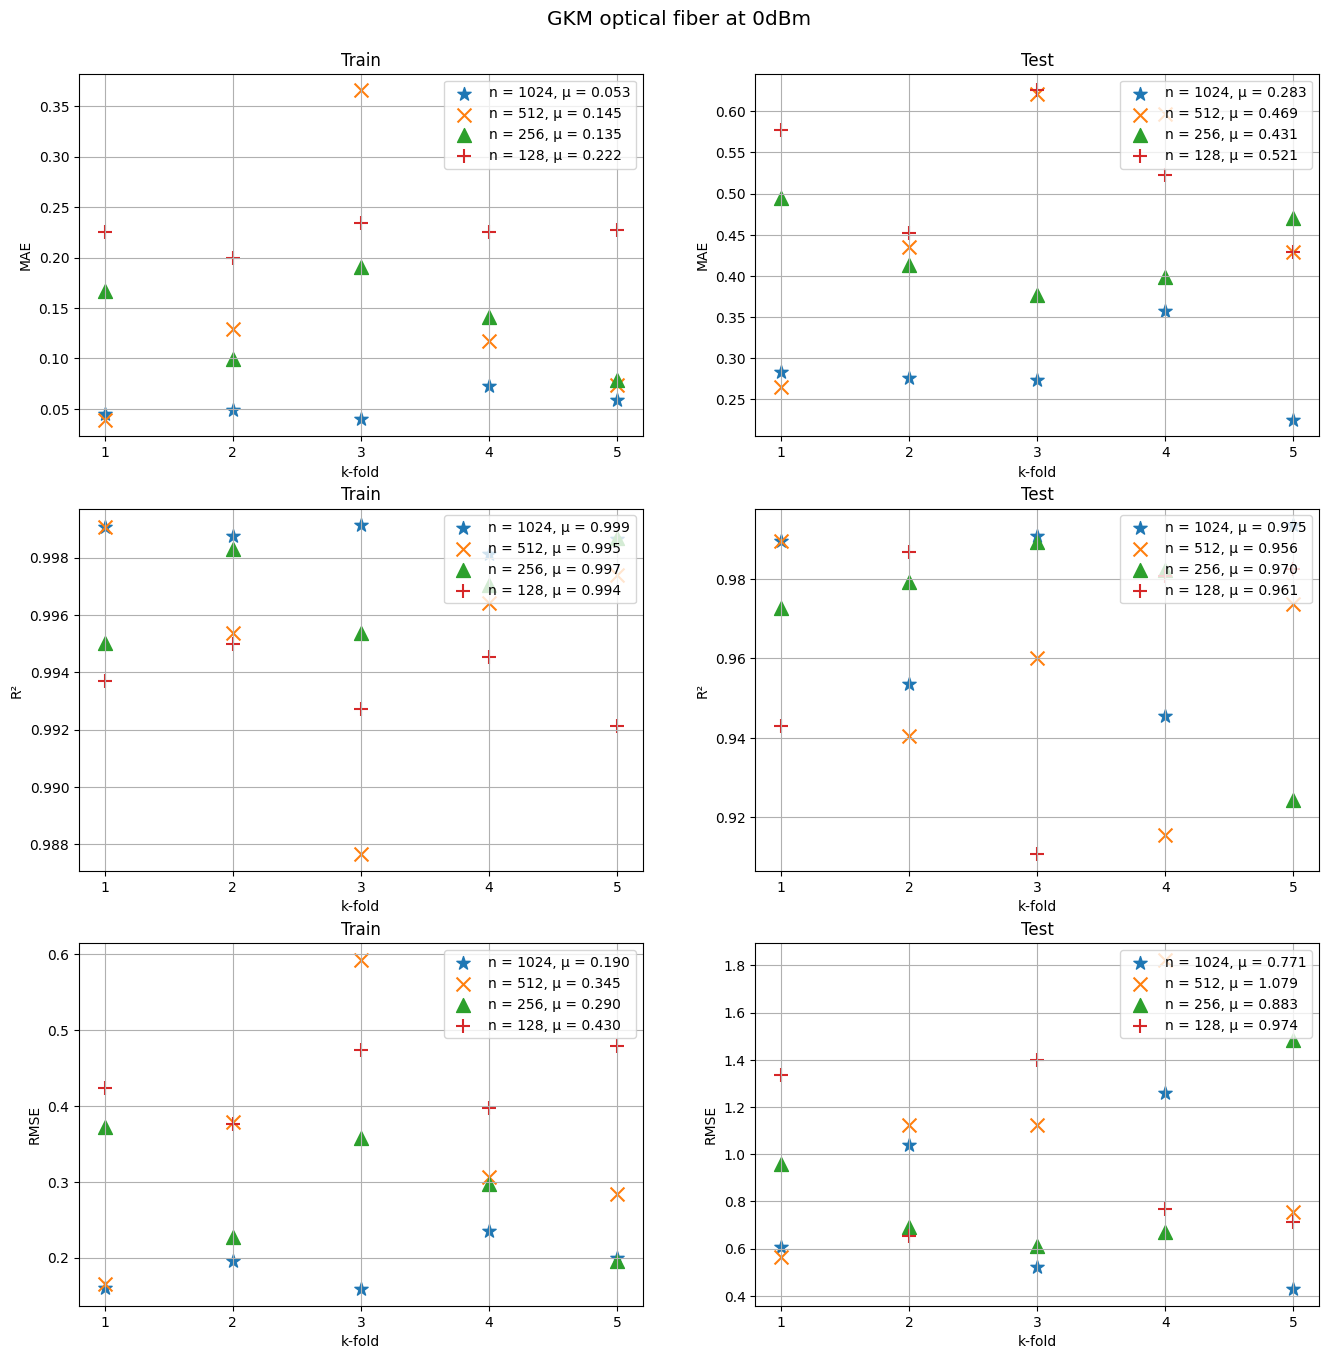

In [34]:
scores = [scores_GKM_1024_fiber0, scores_GKM_512_fiber0, scores_GKM_256_fiber0, scores_GKM_128_fiber0]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "GKM optical fiber at 0dBm")

### Crosvalidación para GKM con fibra óptica a 9dBm variando el número de neuronas por capa

In [35]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_fiber9 = calc_once("scores_GKM_1024_fiber9", test_model, args)

In [36]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_fiber9 = calc_once("scores_GKM_512_fiber9", test_model, args)

In [37]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_fiber9 = calc_once("scores_GKM_256_fiber9", test_model, args)

In [38]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_fiber9 = calc_once("scores_GKM_128_fiber9", test_model, args)

In [39]:
%store scores_GKM_1024_fiber9
%store scores_GKM_512_fiber9
%store scores_GKM_256_fiber9
%store scores_GKM_128_fiber9

Stored 'scores_GKM_1024_fiber9' (dict)
Stored 'scores_GKM_512_fiber9' (dict)
Stored 'scores_GKM_256_fiber9' (dict)
Stored 'scores_GKM_128_fiber9' (dict)


#### Gráficas de puntajes (GKM con fibra óptica a 9dBm)

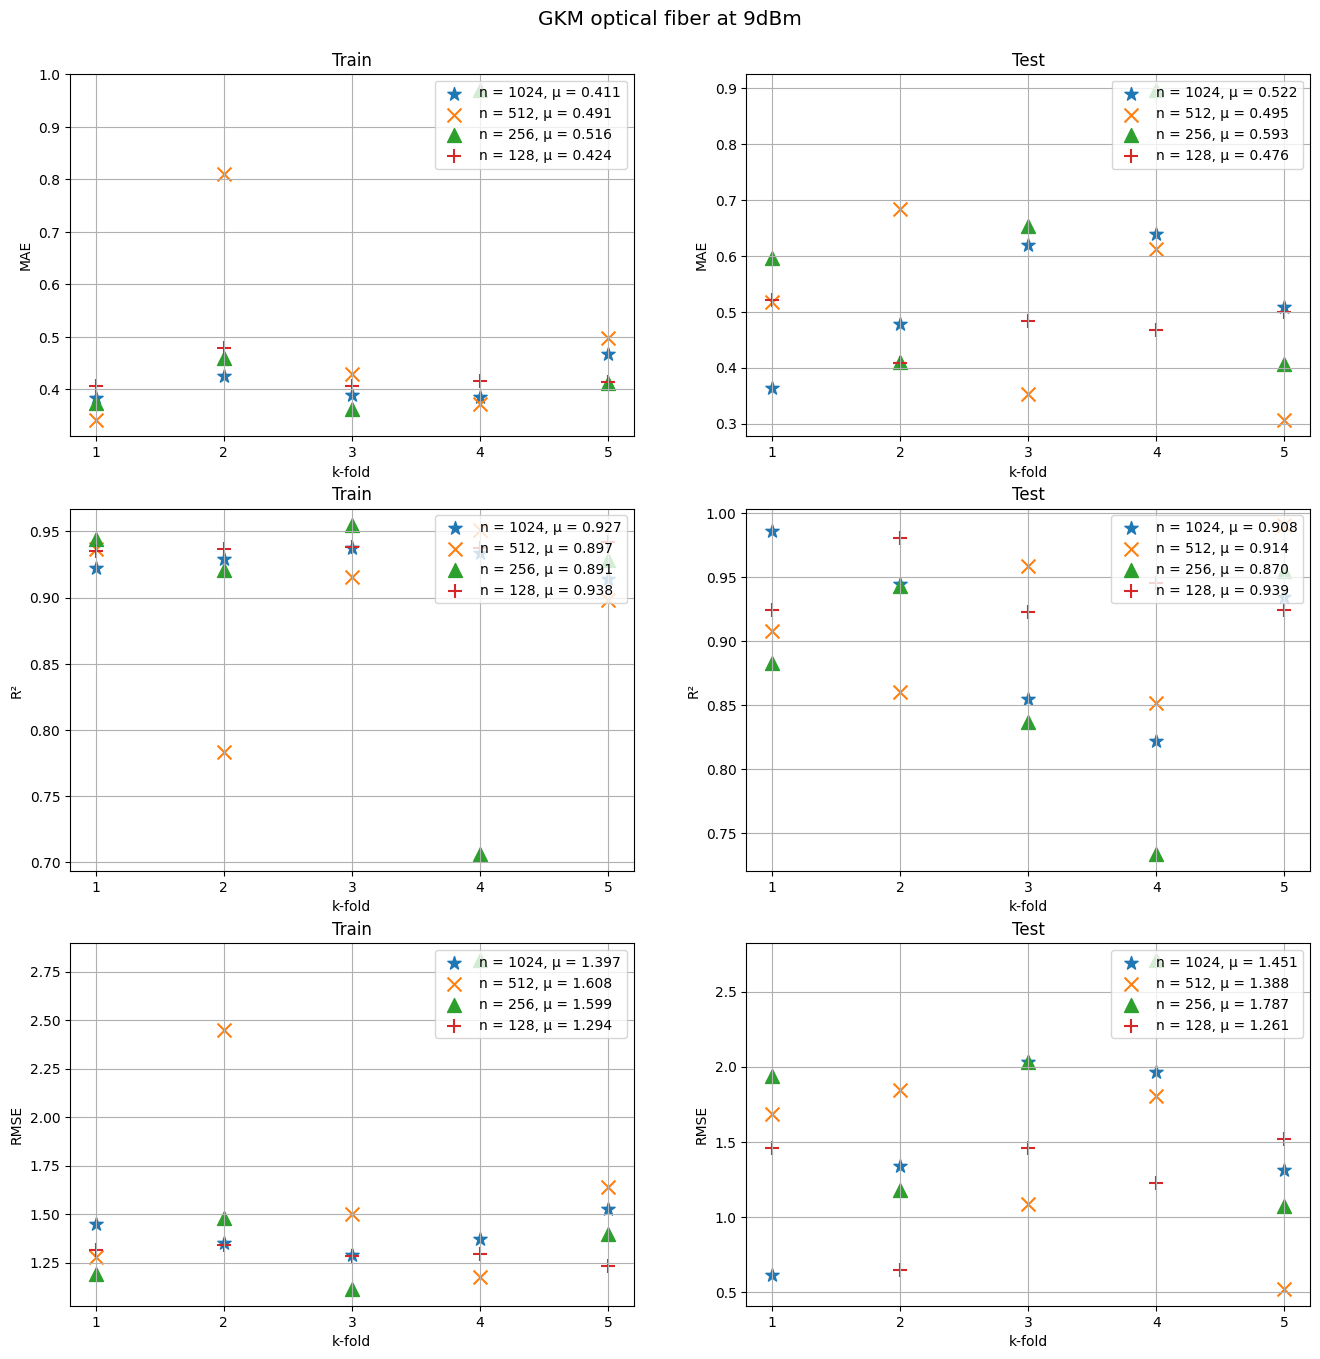

In [40]:
scores = [scores_GKM_1024_fiber9, scores_GKM_512_fiber9, scores_GKM_256_fiber9, scores_GKM_128_fiber9]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "GKM optical fiber at 9dBm")

## FCM y GKM usando 512 máximo número de neuronas y cambiando ReLu por Swish

### Crosvalidación para B2B variando la función ReLu por Swish

In [41]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_relu_B2B = calc_once("scores_FCM_relu_B2B", test_model, args)

In [42]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_relu_B2B = calc_once("scores_GKM_relu_B2B", test_model, args)

In [43]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_FCM_swish_B2B = calc_once("scores_FCM_swish_B2B", test_model, args)

In [44]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_GKM_swish_B2B = calc_once("scores_GKM_swish_B2B", test_model, args)

In [45]:
%store scores_FCM_relu_B2B
%store scores_GKM_relu_B2B
%store scores_FCM_swish_B2B
%store scores_GKM_swish_B2B

Stored 'scores_FCM_relu_B2B' (dict)
Stored 'scores_GKM_relu_B2B' (dict)
Stored 'scores_FCM_swish_B2B' (dict)
Stored 'scores_GKM_swish_B2B' (dict)


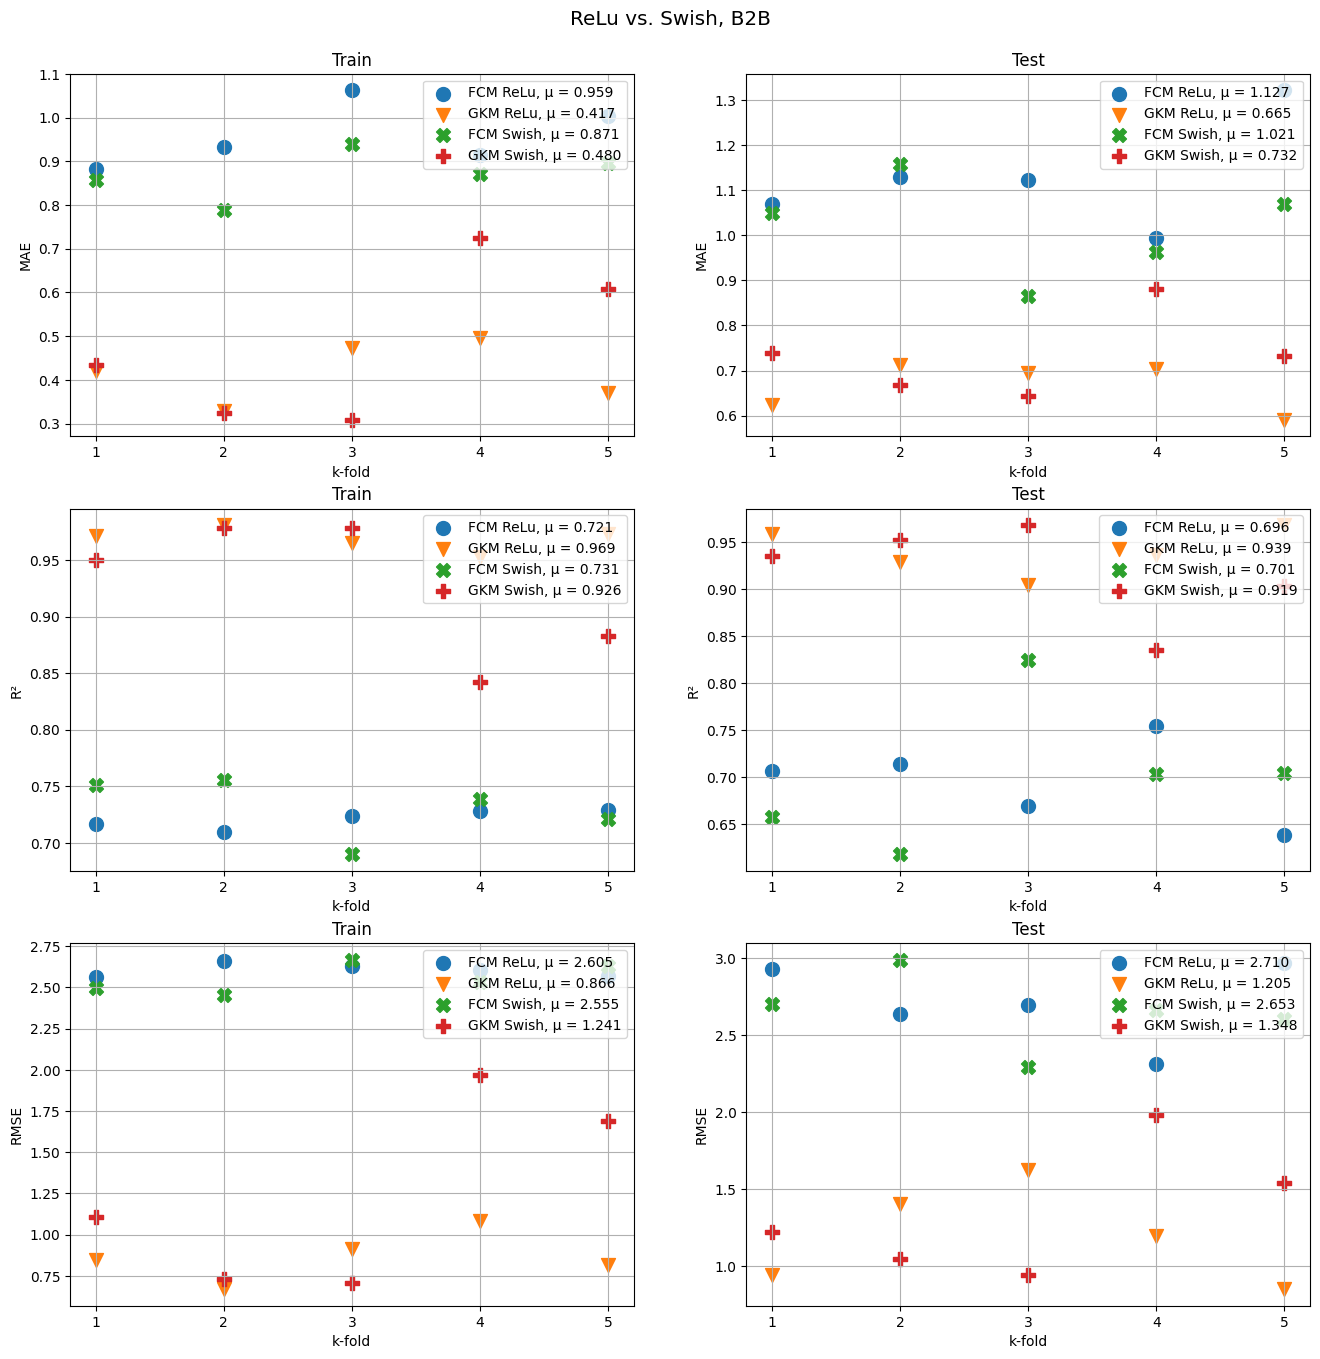

In [46]:
scores = [scores_FCM_relu_B2B, scores_GKM_relu_B2B, scores_FCM_swish_B2B, scores_GKM_swish_B2B]
plot_activations_scores(scores, "ReLu vs. Swish, B2B")

### Crosvalidación para fibra óptica a 0dBm variando la función ReLu por Swish

In [47]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_relu_fiber0 = calc_once("scores_FCM_relu_fiber0", test_model, args)

In [48]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_relu_fiber0 = calc_once("scores_GKM_relu_fiber0", test_model, args)

In [49]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_FCM_swish_fiber0 = calc_once("scores_FCM_swish_fiber0", test_model, args)

In [50]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_GKM_swish_fiber0 = calc_once("scores_GKM_swish_fiber0", test_model, args)

In [51]:
%store scores_FCM_relu_fiber0
%store scores_GKM_relu_fiber0
%store scores_FCM_swish_fiber0
%store scores_GKM_swish_fiber0

Stored 'scores_FCM_relu_fiber0' (dict)
Stored 'scores_GKM_relu_fiber0' (dict)
Stored 'scores_FCM_swish_fiber0' (dict)
Stored 'scores_GKM_swish_fiber0' (dict)


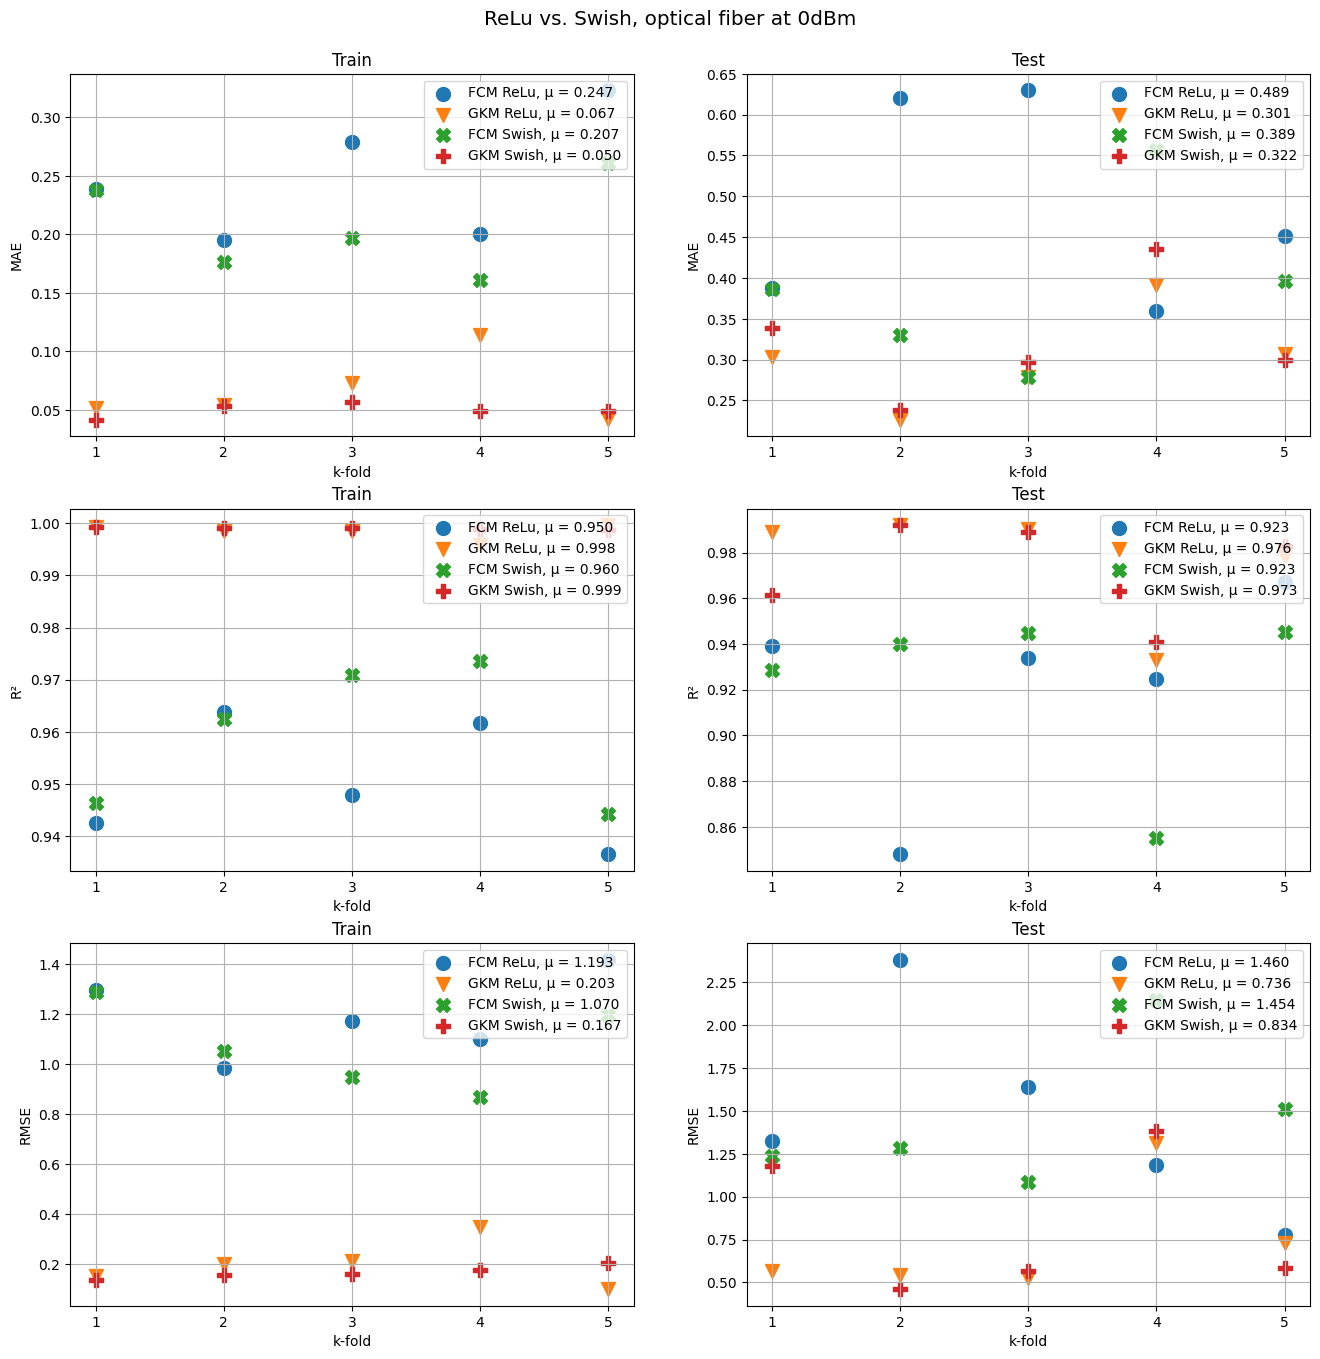

In [52]:
scores = [scores_FCM_relu_fiber0, scores_GKM_relu_fiber0, scores_FCM_swish_fiber0, scores_GKM_swish_fiber0]
plot_activations_scores(scores, "ReLu vs. Swish, optical fiber at 0dBm")

### Crosvalidación para fibra óptica a 9dBm variando la función ReLu por Swish

In [53]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_relu_fiber9 = calc_once("scores_FCM_relu_fiber9", test_model, args)

In [54]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_relu_fiber9 = calc_once("scores_GKM_relu_fiber9", test_model, args)

In [55]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_FCM_swish_fiber9 = calc_once("scores_FCM_swish_fiber9", test_model, args)

In [56]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_GKM_swish_fiber9 = calc_once("scores_GKM_swish_fiber9", test_model, args)

In [57]:
%store scores_FCM_relu_fiber9
%store scores_GKM_relu_fiber9
%store scores_FCM_swish_fiber9
%store scores_GKM_swish_fiber9

Stored 'scores_FCM_relu_fiber9' (dict)
Stored 'scores_GKM_relu_fiber9' (dict)
Stored 'scores_FCM_swish_fiber9' (dict)
Stored 'scores_GKM_swish_fiber9' (dict)


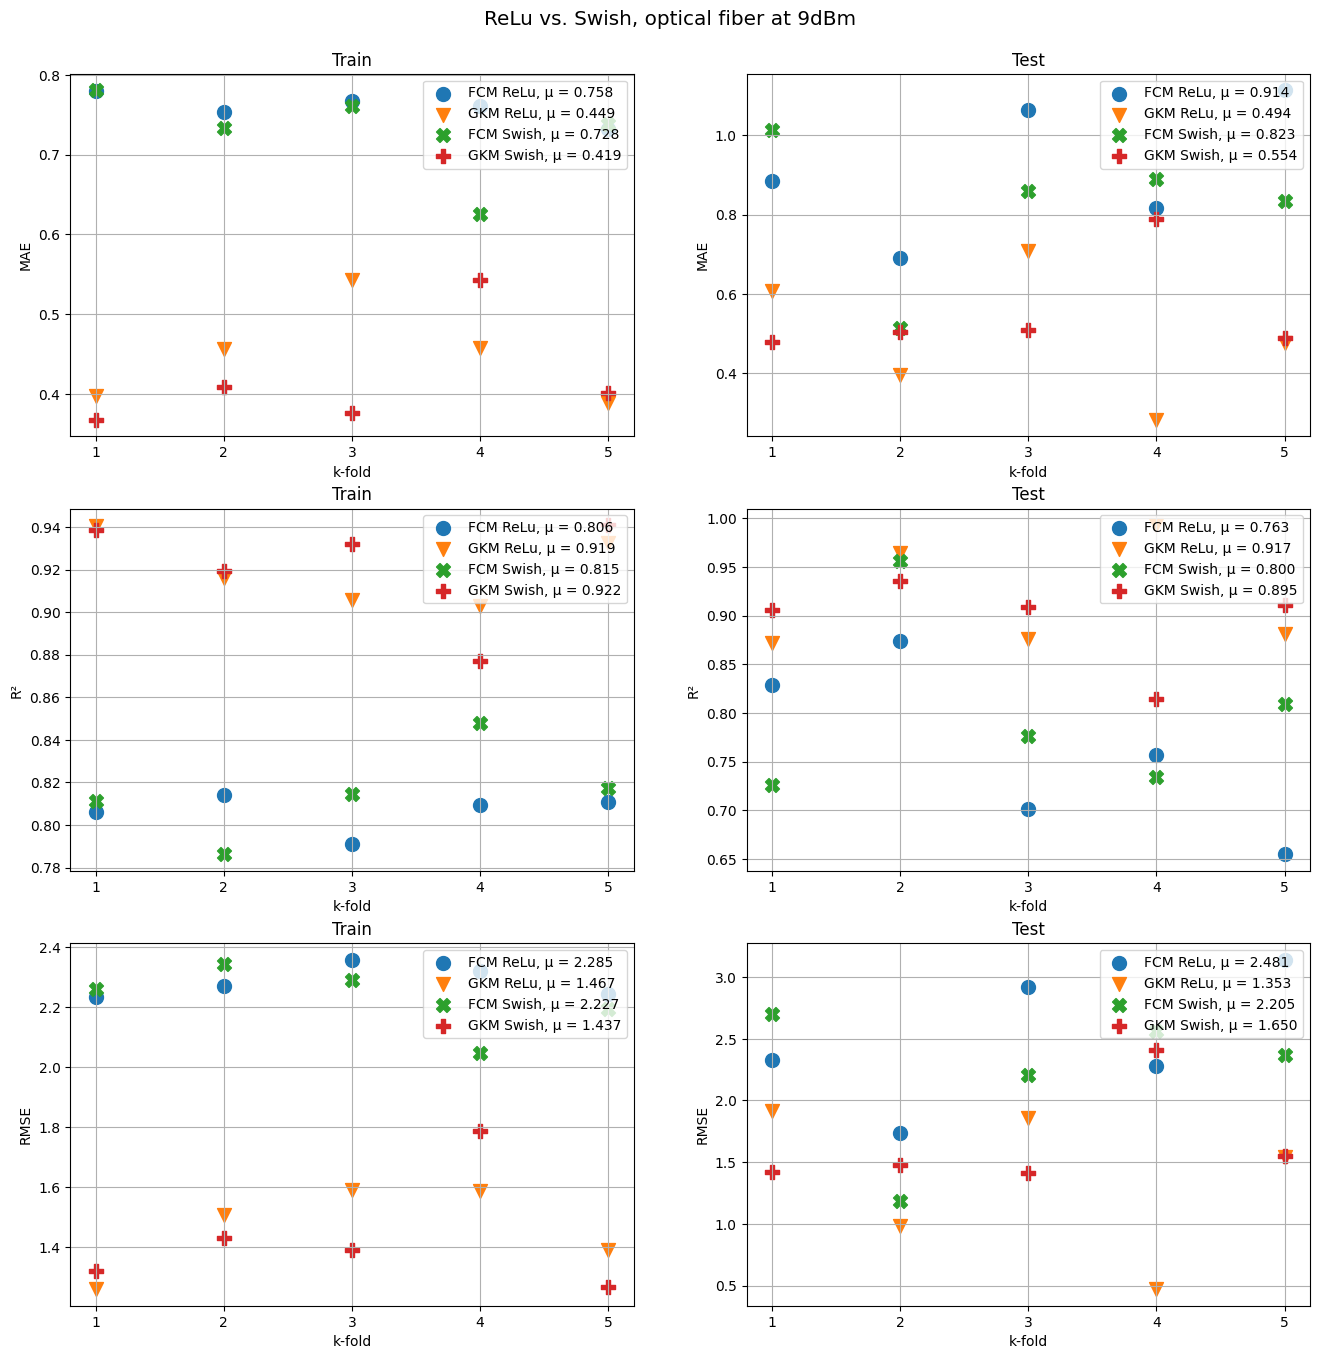

In [58]:
scores = [scores_FCM_relu_fiber9, scores_GKM_relu_fiber9, scores_FCM_swish_fiber9, scores_GKM_swish_fiber9]
plot_activations_scores(scores, "ReLu vs. Swish, optical fiber at 9dBm")